In [1]:
from sklearn.metrics import accuracy_score
from zipfile import ZipFile
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

<p style="font-size: 20px;">Step 1: Importing the data</p>

In [7]:
cd /Users/almamydiop/.kaggle/

/Users/almamydiop/.kaggle


In [19]:
cd  ~/.kaggle

/Users/almamydiop/.kaggle


In [23]:
mkdir ~/.kaggle
cp /Users/almamydiop/Downloads/kaggle.json /Users/almamydiop/.kaggle/kaggle.json
cd ~/.kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
dataset = "/Users/almamydiop/.kaggle/sentiment140.zip"
with ZipFile(dataset,"r") as zips:
    zips.extractall()
    print("dataset extracted")
columns = ["target","id","date","query_type","name","tweet"]
twitter_data = pd.read_csv("/Users/almamydiop/.kaggle/training.1600000.processed.noemoticon.csv",names=columns,encoding="ISO-8859-1")

dataset extracted


Importing the stopwords

In [29]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/almamydiop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
def stemming(content):
        cont = re.sub("[^a-zA-Z']"," ",content)
        cont = cont.lower()
        return cont
def stemming1(content):
        cont = re.sub(r"http://", " ", content)
        cont = re.sub(r"http://[^\s/$.?#].[^\s]*", " ", content)
        cont = cont.lower()
        return cont
def stemming3(content):
        port_stem = PorterStemmer()
        stemmed_cont = content.split()
        stemmed_cont = [port_stem.stem(word) for word in stemmed_cont if not word in stop]
        stemmed_cont = " ".join(stemmed_cont)
        return stemmed_cont

<p style="font-size: 17px;">Class handler for the data</p>

In [71]:
class tweeter_handler:
    def __init__(self,twitter_data):
        self.data = twitter_data
    def transform_data(self):
        self.data["tweet"] = self.data["tweet"].apply(stemming)
        self.data["tweet"] = self.data["tweet"].apply(stemming1)
        self.data["tweet"] = self.data["tweet"].apply(stemming3)
        print("data transformed")
    def prepare_for_model(self):
        self.data.replace({"target":{4:1}},inplace=True)
        self.X = self.data["tweet"]
        self.Y = self.data["target"]
        self.X_train,self.X_test,self.Y_train,self.Y_test = train_test_split(self.X,self.Y,test_size=0.25,stratify=self.Y, random_state=2)
        vectorizer = TfidfVectorizer(stop_words="english")
        self.X_train = vectorizer.fit_transform(self.X_train)
        self.X_test = vectorizer.transform(self.X_test)
        print("data vectorized and train test split applied")
    def predict(self):
        self.model = MultinomialNB()
        self.model.fit(self.X_train,self.Y_train)
        self.prediction = self.model.predict(self.X_test)
        print(f"accuracy score {accuracy_score(self.Y_test,self.prediction)}")
    def save_model(self):
        filename = "NLPmodel.sav"
        pickle.dump(self.model,open(filename,"wb"))
        
        

In [72]:
classtweet = tweeter_handler(twitter_data)

In [73]:
classtweet.transform_data()

data transformed


In [74]:
classtweet.prepare_for_model()

data vectorized and train test split applied


In [75]:
classtweet.predict()

accuracy score 0.7522625


In [76]:
classtweet.save_model()

<p style="font-size: 20px;">Exploratory Data Analysis</p>

Length of tweets (Number of characters in Tweet)

<Axes: >

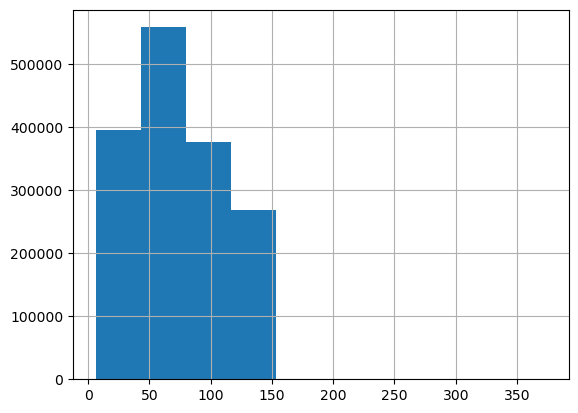

In [80]:
twitter_data["tweet"].str.len().hist()

Numbers of words in Tweet

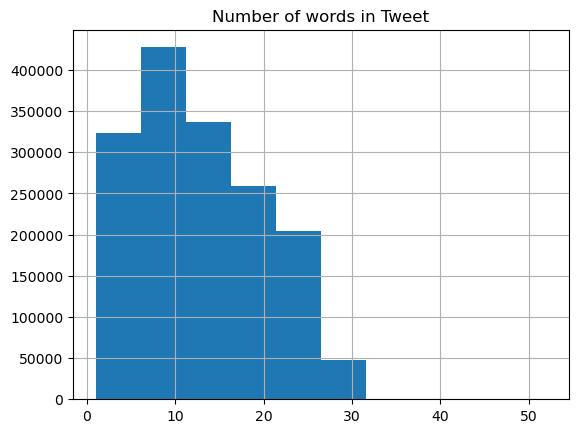

In [87]:
twitter_data["tweet"].str.split().map(lambda x: len(x)).hist()
plt.title("Number of words in Tweet");

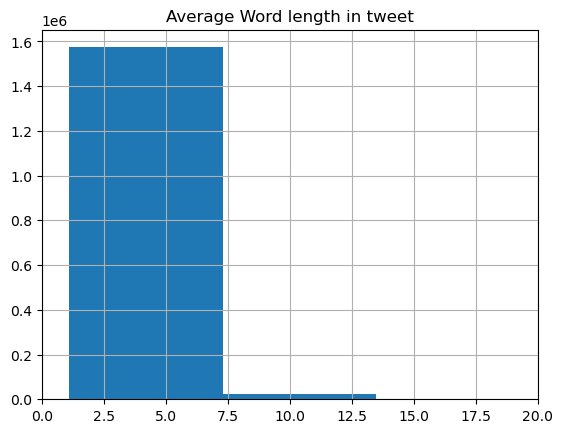

In [92]:
twitter_data["tweet"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.xlim(0, 20) 
plt.title("Average Word length in tweet");

In [114]:
corpus=[]
new= twitter_data['tweet'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop and len(word)>5:
        dic[word]+=1

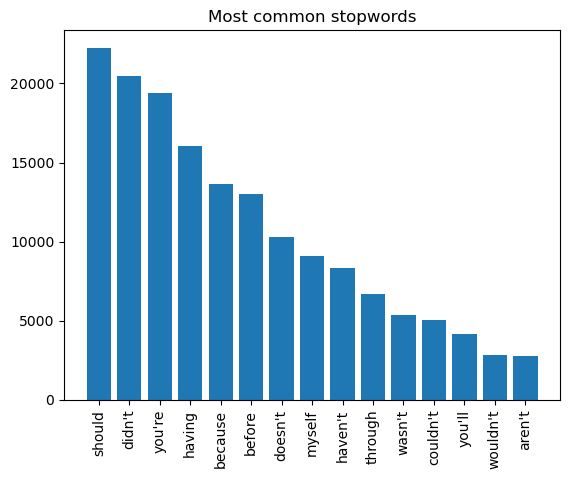

In [122]:
D = dict(sorted(dic.items(), key=lambda x: x[1],reverse=True)[:15])
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.xticks(rotation=90)
plt.title("Most common stopwords");

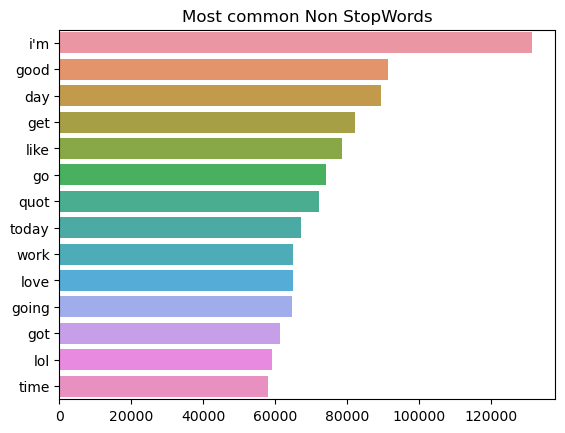

In [133]:
counter=Counter(corpus)
most=counter.most_common()
x, y= [], []
for word,count in most[:50]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.title("Most common Non StopWords");

In [141]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:15]

In [172]:
top_2_bigrams=get_top_ngram(corpus,2)

In [174]:
x1, y1= [], []
for word,count in top_2_bigrams:
    
    x1.append(word)
    y1.append(count)

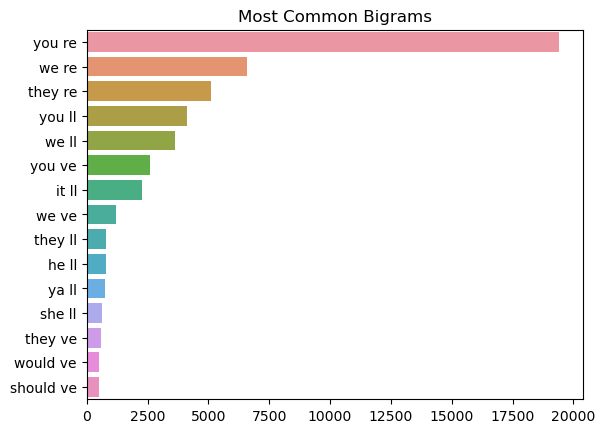

In [176]:
sns.barplot(x=y1,y=x1)
plt.title("Most Common Bigrams");

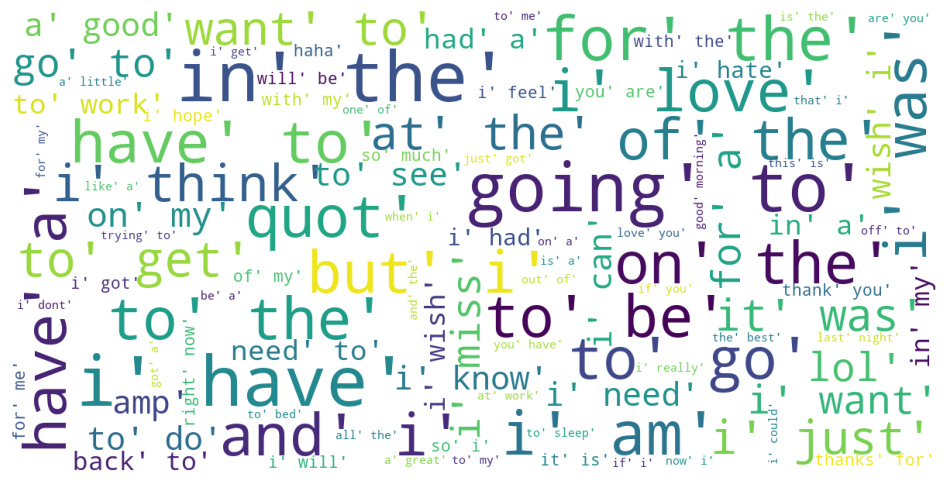

In [186]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

<p style="font-size: 17px;">Saving the model</p>

In [281]:
filename = "NLPmodel.sav"
pickle.dump(model,open(filename,"wb"))